# Ejemplo para predecir el valor del mercado del Bitcoin

**Utilizando LSTM de una red recurrente**

La idea es que la Red LSTM aprenda a predecir los valores del BTC en los proximos dias o meses.

**Importar Librerias**

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

**Cargar Data**

In [21]:
dataset = pd.read_csv('historicoBTC.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-07-31,"23,294.0","23,639.0","24,211.0","23,233.0",3.15K,-1.46%
2022-07-30,"23,639.0","23,764.0","24,641.0","23,520.0",4.30K,-0.53%
2022-07-29,"23,764.0","23,851.6","24,426.0","23,456.0",5.03K,-0.37%
2022-07-28,"23,851.6","22,951.0","24,172.0","22,601.0",6.63K,3.92%
2022-07-27,"22,951.0","21,271.0","23,098.0","21,056.0",7.47K,7.90%


Grafico del valor del BTC hasta Julio del 2022

**Pre procesamiento de los Datos**

Vamos a  crear los datos de entrenamiento y los datos de validacion
Para los datos de entramiento voy a usar los datos de Enero a Myo y para los de validacion los datos de Junio y Julio



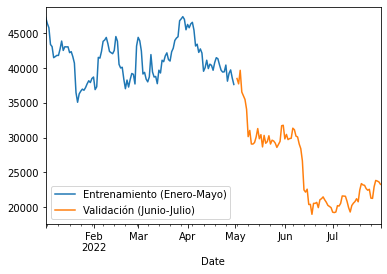

In [120]:
dataset = pd.DataFrame(dataset)

dataset['Price'] =[float(str(i).replace(",", "")) for i in dataset['Price'] ]

set_entrenamiento= dataset.loc['2022-01-01':'2022-04-30'].iloc[:,0:1]
set_validacion = dataset.loc['2022-05-01':'2022-07-31'].iloc[:,0:1]

set_entrenamiento['Price'].plot(legend=True)
set_validacion['Price'].plot(legend=True)
plt.legend(['Entrenamiento (Enero-Mayo)', 'Validación (Junio-Julio)'])
plt.show()

**Normalizamos los datos**

Para que la Red LSTM pueda ser entrenada que los valores de la acción se encuentran en un rango definido. Así que vamos a normalizar estos valores en el rango de 0 a 1, usando la función MinMaxScaler

In [121]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

Para entrenar la Red LSTM tomaremos bloques de 20 datos consecutivos, y la idea es que cada uno de estos permita predecir el siguiente valor

Los bloques de 20 datos serán almacenados en la variable X, mientras que el dato que se debe predecir (el dato 61 dentro de cada secuencia) se almacenará en la variable Y y será usado como la salida de la Red LSTM

In [122]:
time_step = 20
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

Este codigo permite dividir el set de entrenamiento en bloques de 20 datos y almacenar los bloques correspondientes en diferentes posiciones de las variables X_train y Y_train.

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de 20x1. Para eso se usa la función reshape de Numpy

In [123]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

**Creo el Modelo**

Para crear la red debemos primero definir el tamaño de los datos de entrada y del dato de salida, así como el número total de neuronas (50)

HiperParametos

In [124]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
neuronas = 50

**Definir el modelo**

In [125]:
modelo = Sequential()
modelo.add(LSTM(units=neuronas, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

Se crea la Red LSTM usando el módulo Sequential
Luego se añade a la Red LSTM usando la función add, especificando el número de neuronas a usar (parámetro units) y el tamaño de cada dato de entrada (parámetro input_shape)

Para la capa de salida usamos la función Dense y especificamos que el dato de salida tendrá un tamaño igual a 1 (parámetro units)

**Compilamos**

In [126]:
modelo.compile(optimizer='sgd', loss='mse')

Ahora se compila el modelo, definiendo así la función de error (parámetro loss) así como el método que se usará para minimizarla (parámetro optimizer)

El optimizador seleccionado (rmsprop) funciona de manera similar al algoritmo del Gradiente Descendente, mientras que la función de error es el error cuadrático medio

**Entreno el Modelo**

 En este caso usaremos un total de 20 iteraciones (parámetro epochs) y presentaremos a la Red LSTM lotes de 32 datos (parámetro batch_size).


In [127]:
modelo.fit(X_train,Y_train,epochs=50,batch_size=32)

Epoch 1/50
4/4 [==============================] - 2s 11ms/step - loss: 0.2072
Epoch 2/50
4/4 [==============================] - 0s 12ms/step - loss: 0.1133
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0749
Epoch 4/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0601
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0523
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0494
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0478
Epoch 8/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0468
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0470
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0460
Epoch 11/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0458
Epoch 12/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0464
Epoch 13/50
4/4 [==============================] - 0s 15ms/st

**Evaluamos el modelo (Predicciones)**

Debemos preparar el set de validación, normalizando inicialmente los datos, en el rango de 0 a 1.

Este modelo fue entrenado para tomar 20 y generar un dato como predicción. Así que debemos reorganizar el set de validación (x_test) para que tenga bloques de 20 datos

In [128]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

**Predicciones**


In [134]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

**Graficamos**


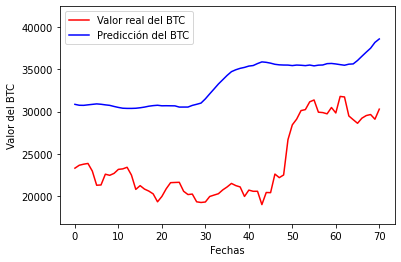

In [130]:
plt.plot(set_validacion.values[0:len(prediccion)],color='red', label='Valor real del BTC')
plt.plot(prediccion, color='blue', label='Predicción del BTC')
plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
plt.xlabel('Fechas')
plt.ylabel('Valor del BTC')
plt.legend()
plt.show()